# GENERAR GIF EVOLUCIÓN URBANÍSTICA

Gracias a este script podrás generar un gif con la evolución urbanística de un área geográfica determinada.

Para ello solo tienes que ejecutar todas las celdas en orden y subir varias imágenes satelitales del área de la que deseas conocer su evolución en diferentes en diferentes épocas.

Finalmente podrás descargar el gif resultado.
Código de colores:
-	Verde: edificios de la primera imágen.
-	Azul: nuevos edificios en las sucesivas imágenes.
-	Rojo: edificios que desaparecen de una imagen a la siguiente.

In [8]:
# @title Intalar e importar librerias
!pip install transformers==4.27.1

import numpy as np
from PIL import Image, ImageDraw
import imageio
import tensorflow as tf
import pandas as pd

import os
import cv2
import torch
import torchvision
from torch.optim import AdamW
from transformers import SegformerForSemanticSegmentation
from torch import load

import requests
from io import BytesIO

from IPython.display import Image as IPImage
from IPython.display import display

In [4]:
# @title Descarga y carga del modelo preentrenado

# Enlace de descarga directa de Dropbox
url = "https://dl.dropboxusercontent.com/scl/fi/upywaddunnqr1pv4n2tm6/best_model.pth?rlkey=6980bkytyn4z49ztgl2pgjh7u&dl=1"

# Descargar los pesos del modelo
response = requests.get(url)
if response.status_code == 200:
    with open('modelo_descargado.pth', 'wb') as f:
        f.write(response.content)

# CSV con las clases a identificar
data = {
    'name': ['unlabeled', 'building'],
    'r': [0, 1],
    'g': [0, 1],
    'b': [0, 1]
}

# Creamos un DataFrame con los datos
df = pd.DataFrame(data)

classes = df['name']
palette = df[['r', 'g', 'b']].values
id2label = classes.to_dict()
label2id = {v: k for k, v in id2label.items()}


# Carga del modelo preentrenado
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b5",
                                                         ignore_mismatched_sizes=True,
                                                         num_labels=len(id2label),
                                                         id2label=id2label,
                                                         label2id=label2id,
                                                         reshape_last_stage=True)

if torch.cuda.is_available():
    checkpoint = torch.load('modelo_descargado.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
else:
    checkpoint = torch.load('modelo_descargado.pth', map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['model_state_dict'])

optimizer = AdamW(model.parameters(), lr=0.00006)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

(…)o/nvidia/mit-b5/resolve/main/config.json:   0%|          | 0.00/70.0k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/328M [00:00<?, ?B/s]

Some weights of the model checkpoint at nvidia/mit-b5 were not used when initializing SegformerForSemanticSegmentation: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b5 and are newly initialized: ['decode_head.linear_c.0.proj.bias', 'decode_head.batch_norm.running_var', 'decode_head.linear_c.2.proj.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.linear_c.1.proj.weight', 'deco

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)

In [15]:
# @title Cargar los métodos para realizar el procesado

def predict_masks(images_list, model, device='cuda'):
    """
    Devuelve las máscaras predichas para una lista de imágenes.
    Las imágenes son divididas en porciones de 1000x1000 para la predicción.
    """
    masks = []

    for img in images_list:
        subimages, original_size = split_into_subimages(img)
        submasks_list = []
        for subimage in subimages:
            pixel_values = torchvision.transforms.functional.to_tensor(subimage).unsqueeze(0).to(device)

            with torch.no_grad():
                outputs = model(pixel_values=pixel_values)

                h, w = subimage.size
                upsampled_logits = torch.nn.functional.interpolate(outputs.logits, size=(h, w), mode="bilinear", align_corners=False)
                predicted = upsampled_logits.argmax(dim=1)

                pred_labels = predicted.detach().cpu().numpy()#.flatten()
                submasks_list.append(pred_labels)

        mask = combine_submasks(submasks_list, original_size)
        masks.append(mask)

    return masks


def detect_new_objects(prev_mask, current_mask, threshold=0.5):
    """Detecta los nuevos objetos en la máscara actual respecto a la máscara previa."""
    prev_bin = (prev_mask > threshold).astype(np.int8)
    curr_bin = (current_mask > threshold).astype(np.int8)

    new_objects = curr_bin - prev_bin

    return new_objects


def split_into_subimages(image, subimage_size=(1000, 1000)):
    """
    Divide una imagen en subimágenes de tamaño subimage_size.
    Si una imagen no es divisible exactamente por subimage_size, se aplica padding.
    """
    width, height = image.size
    new_width, new_height = subimage_size
    pad_width = (new_width - (width % new_width)) % new_width
    pad_height = (new_height - (height % new_height)) % new_height

    # Aplicar padding
    padded_image = Image.new(image.mode, (width + pad_width, height + pad_height), color=0)
    padded_image.paste(image, (0, 0))

    subimages = []
    for i in range(0, padded_image.width, new_width):
        for j in range(0, padded_image.height, new_height):
            subimage = padded_image.crop((i, j, i + new_width, j + new_height))
            subimages.append(subimage)

    return subimages, (width, height)


def combine_submasks(submasks, original_size, subimage_size=(1000, 1000)):
    width, height = original_size
    combined_mask = Image.new("L", (width, height))  # Crear una imagen en blanco y negro
    idx = 0
    new_width, new_height = subimage_size
    for i in range(0, width, new_width):
        for j in range(0, height, new_height):
            # Convertir el numpy array a imagen PIL
            submask_pil = Image.fromarray((submasks[idx].squeeze()*255).astype(np.uint8))
            combined_mask.paste(submask_pil, (i, j))
            idx += 1

    return combined_mask


def generate_gif(images_list, masks_list):
    """Genera un GIF con las máscaras y resalta nuevos objetos."""
    frames = []
    prev_mask = None
    for img, mask in zip(images_list, masks_list):
        mask_image = Image.new('RGB', img.size)
        draw = ImageDraw.Draw(mask_image)

        # Convertir la imagen 'mask' a un array numpy
        mask_array = np.asarray(mask)

        # Rellenar con máscaras existentes
        for x in range(img.width):
            for y in range(img.height):
                if mask_array[y, x] > 0.5:
                    draw.point((x, y), fill=(0, 255, 0))

        if prev_mask is not None:
            # Convertir la imagen 'prev_mask' a un array numpy
            prev_mask_array = np.asarray(prev_mask)

            new_objects = detect_new_objects(prev_mask_array, mask_array)

            for x in range(img.width):
                for y in range(img.height):
                    if new_objects[y, x] == 1:
                        draw.point((x, y), fill=(0, 0, 255))  # Azul para nuevos edificios
                    elif new_objects[y, x] == -1:
                        draw.point((x, y), fill=(255, 0, 0))  # Rojo para edificios que desaparecen

        prev_mask = mask_array
        frames.append(mask_image)

    # Guarda el GIF resultante
    gif_path = 'resultado.gif'
    imageio.mimsave(gif_path, frames, duration=1000, loop=0)

    # Imprimir Gif
    with open(gif_path, 'rb') as f:
        display(IPImage(data=f.read(), format='png')) #, width=250, height=250

In [16]:
# @title Subir imágenes, puedes elegir varias a la vez

from google.colab import files

image_paths = []
images_list = []

# Función para cargar archivos desde tu sistema
uploaded = files.upload()

# Guardar los archivos subidos y abrir las imágenes
for filename in uploaded.keys():
  # Guardar cada archivo subido al entorno de Colab
  with open(filename, 'wb') as f:
    f.write(uploaded[filename])
    image_paths.append(filename)  # Añadir la ruta del archivo a la lista

# Una vez guardados, puedes cargar las imágenes en una lista
images_list = [Image.open(path) for path in image_paths]

Saving prueba0.jpg to prueba0.jpg
Saving prueba1.jpg to prueba1.jpg
Saving prueba3.jpg to prueba3.jpg
Saving prueba2.jpg to prueba2.jpg


Imagen 1: 1377 edificios detectados.
Imagen 2: 943 edificios detectados.
Imagen 3: 1280 edificios detectados.
Imagen 4: 937 edificios detectados.


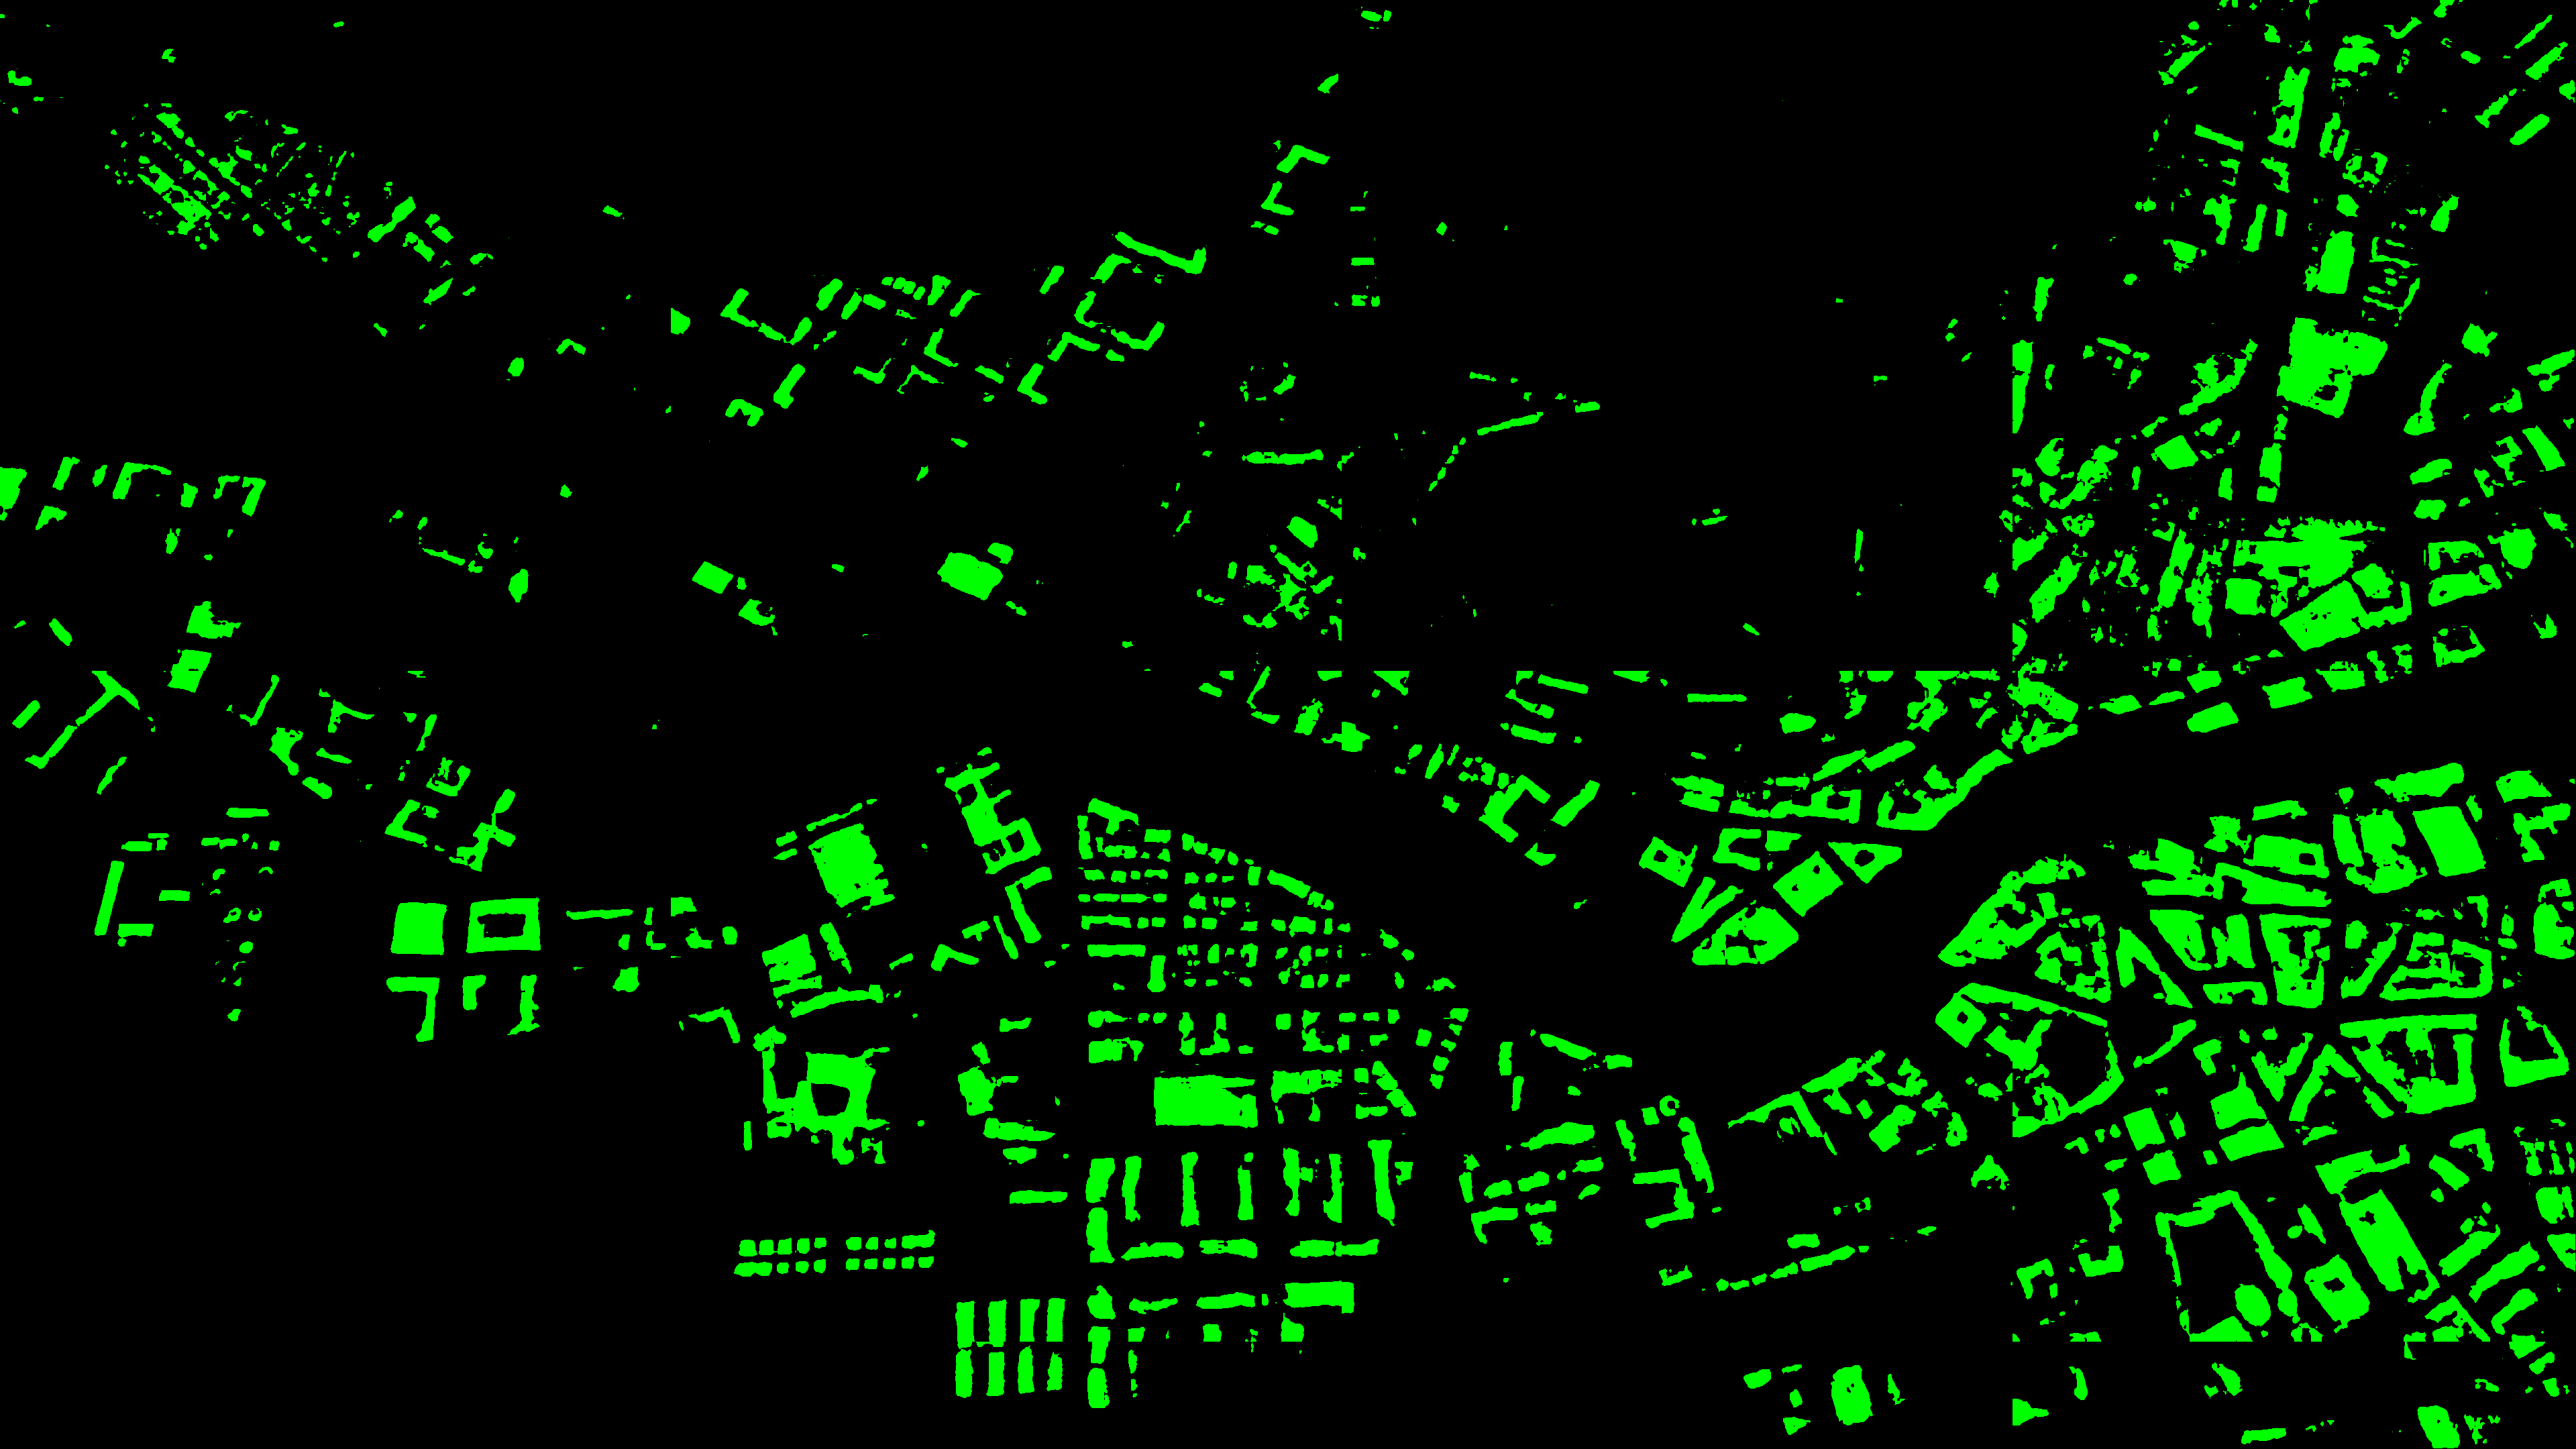

In [19]:
# @title Ejecutar instrucciones
from scipy.ndimage import label

# Predicción de máscaras
masks_list = predict_masks(images_list, model)

# Imprimir el número de edificios en cada imagen
for i, mask in enumerate(masks_list):
    mask_array = np.asarray(mask) > 0.5  # Esto crea una máscara binaria
    labeled, num_features = label(mask_array)
    print(f"Imagen {i+1}: {num_features} edificios detectados.")

# Crear el GIF
generate_gif(images_list, masks_list)